In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# check xgboost version
from xgboost import XGBClassifier

## alertas
import warnings
warnings.filterwarnings("ignore")

***
### Funções

In [2]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [3]:
def plot_feature_freq(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

In [ ]:
def plot_feature_freq_mes(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1] + counts[2] + counts[3] + counts[4] + counts[5] + counts[6]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

*****
## Coleta de dados

In [4]:
FILE = "/kaggle/input/bigdata/batdtfim_full.csv"

In [5]:
client_chunks = []
dados_teste = pd.read_csv(FILE, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [6]:
for chunk in dados_teste:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
#     new_clients = new_clients.sample(frac = 0.01)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

dados = pd.concat(client_chunks).reset_index(drop = True)

In [7]:
# FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
# dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.idade': 'idade'})\
             .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
             .rename(columns={'a.avg_cpf': 'avg_cpf'})\
#              .drop_duplicates().reset_index(drop=True)

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf
0,5511910001022,724102007034575,35501610,2020-12-29,2022-02-12,13,1,1,SAMSUNG,"GALAXY S10E (SM-G970F,DS)",...,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 20GB+220GB BONUS,0.00,0.0,1.0,0.0,2018.0,54.0,13.0,13.0
1,5511910005207,724101993391706,35658611,2021-04-20,NaN,18,1,0,LG,LM-K420BMW,...,SAO PAULO,VIVO CONTROLE 7GB_,53.35,0.0,1.0,0.0,2020.0,35.0,0.0,0.0
2,5511910005218,724102090675583,35462311,2020-12-17,2022-03-24,15,1,1,Samsung Korea,GALAXY A10S,...,SAO PAULO,VIVO CONTROLE 4GB,37.61,0.0,1.0,0.0,2019.0,43.0,15.0,15.0
3,5511910010851,724100500592447,86135502,2021-10-16,NaN,12,1,0,Shenzhen Gionee Communication Equipment Co Ltd,GIONEE M100,...,SAO PAULO,VIVO CONTROLE DIG-7GB_,53.35,0.0,0.0,0.0,2013.0,80.0,0.0,0.0
4,5511910011500,724102091149832,35583108,2021-03-24,2022-04-19,12,1,1,APPLE,IPHONE 7 (A1660),...,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,0.00,0.0,1.0,0.0,2016.0,62.0,0.0,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7909329,5599992311385,724119815091378,35570711,2021-06-24,NaN,15,1,0,SAMSUNG,"GALAXY A51 (SM-A515F,DSN)",...,MARANHAO,VIVO CONTROLE 7GB_,52.19,0.0,1.0,0.0,2020.0,41.0,17.0,17.0
7909330,5599992316211,724119891126964,35997108,2021-01-11,2022-04-26,15,1,1,SAMSUNG,GALAXY J7 NEO (SM-J701MT),...,MARANHAO,VIVO CTRL DIGITAL-11GB ILIM_,66.20,0.0,1.0,0.0,2017.0,43.0,15.0,15.0
7909331,5599992316415,724119892026372,86717405,2021-04-30,NaN,17,1,0,XIAOMI,REDMI 9A (M2006C3LG),...,MARANHAO,VIVO CONTROLE 7GB_,52.19,0.0,1.0,0.0,2020.0,34.0,0.0,0.0
7909332,5599996511912,724119107272077,35304309,2020-11-19,2022-03-05,15,1,1,APPLE,IPHONE X (A1901),...,MARANHAO,TITULAR VIVO V,1179.99,0.0,1.0,0.0,2017.0,40.0,15.0,15.0


### Limpeza dos dados

In [8]:
just_check_nan(dados)

Dados com NaN:
imsi                             1
dt_fim                     6634955
citydesc                   7909334
statedesc                      580
subscribermainofferdesc      13811
assignedchargeamount         12354
fl_3g                         1587
fl_4g                         1587
fl_5g                         1587
dt_ano_stts                   1587
idade                            3
dtype: int64

columns_with_nan.shape (11,)



In [9]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts'])\
                    .reset_index(drop=True)
# dados_droped

In [10]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      6620115
citydesc    7892679
idade             3
dtype: int64

columns_with_nan.shape (3,)



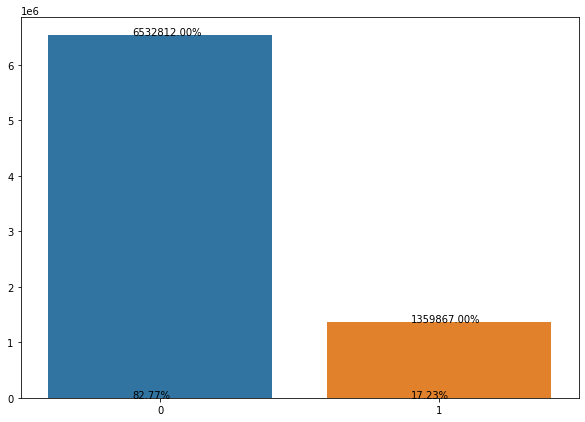

In [11]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

### Equilibrando classes

In [12]:
dados['dt_ano_stts'] = np.asarray(dados['dt_ano_stts'], dtype = 'int16')
dados['idade'] = np.asarray(dados['idade'], dtype = 'int16')
dados['fl_3g'] = np.asarray(dados['fl_3g'], dtype = 'int8')
dados['fl_4g'] = np.asarray(dados['fl_4g'], dtype = 'int8')
dados['fl_5g'] = np.asarray(dados['fl_5g'], dtype = 'int8')

In [13]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909334 entries, 0 to 7909333
Data columns (total 29 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   msisdn                   int64  
 1   imsi                     object 
 2   tac                      int64  
 3   dt_inicio                object 
 4   dt_fim                   object 
 5   aging_aparelho           int64  
 6   cat_aparelho             int64  
 7   trocou_aparelho          int64  
 8   fabricante               object 
 9   modelo                   object 
 10  imei                     object 
 11  ranking                  int64  
 12  cpfidentifier            int64  
 13  subscriberkey            int64  
 14  customerkey              int64  
 15  customersubtypedesc      object 
 16  subscriberstatuskey      object 
 17  offertechnology          object 
 18  citydesc                 float64
 19  statedesc                object 
 20  subscribermainofferdesc  object 
 21  assigned

In [14]:
dados.columns

Index(['msisdn', 'imsi', 'tac', 'dt_inicio', 'dt_fim', 'aging_aparelho',
       'cat_aparelho', 'trocou_aparelho', 'fabricante', 'modelo', 'imei',
       'ranking', 'cpfidentifier', 'subscriberkey', 'customerkey',
       'customersubtypedesc', 'subscriberstatuskey', 'offertechnology',
       'citydesc', 'statedesc', 'subscribermainofferdesc',
       'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts',
       'idade', 'avg_msisdn', 'avg_cpf'],
      dtype='object')

***
### Analise individual

In [15]:
dados_droped['trocou_aparelho'].unique()

array([1, 0])

In [16]:
dados_droped['cat_aparelho'].unique()

array([1])

In [17]:
dados_droped['aging_aparelho'].unique()

array([13, 18, 15, 12, 14, 17, 16])

In [18]:
dados_droped['customersubtypedesc'].unique()

array(['Pessoa Física', 'Funcionário Vivo'], dtype=object)

In [19]:
dados_droped['subscriberstatuskey'].unique()

array(['A'], dtype=object)

In [20]:
dados_droped['ranking'].unique()

array([1, 2])

In [21]:
dados_droped['fl_3g'].equals(dados_droped['fl_4g'])

False

In [22]:
dados_droped['fl_3g'].equals(dados_droped['fl_5g'])

False

In [23]:
dados_droped['fl_4g'].equals(dados_droped['fl_5g'])

False

In [24]:
dados_droped['idade'].describe()

count    7.892676e+06
mean     4.660514e+01
std      1.483000e+01
min     -6.181000e+03
25%      3.600000e+01
50%      4.500000e+01
75%      5.700000e+01
max      2.690000e+02
Name: idade, dtype: float64

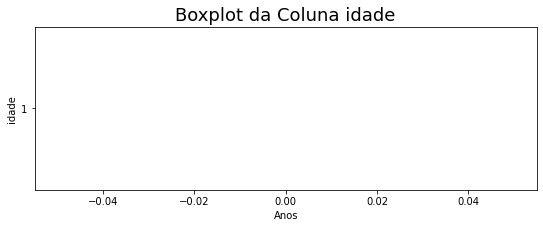

In [38]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(9, 3))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dados_droped['idade'], vert = 0)

# Adicionando Título ao gráfico
plt.title("Boxplot da Coluna idade", loc="center", fontsize=18)
plt.xlabel("Anos")
plt.ylabel("idade")

plt.show()

In [25]:
dados_droped['dt_ano_stts'].describe()

count    7.892679e+06
mean     2.019015e+03
std      1.646664e+00
min      1.999000e+03
25%      2.018000e+03
50%      2.020000e+03
75%      2.020000e+03
max      2.022000e+03
Name: dt_ano_stts, dtype: float64

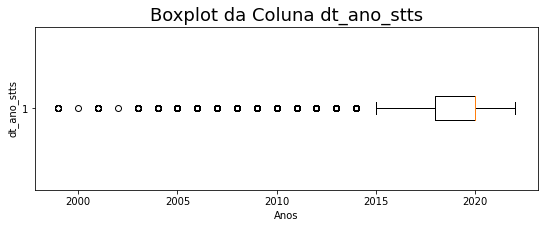

In [26]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(9, 3))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dados_droped['dt_ano_stts'], vert = 0)

# Adicionando Título ao gráfico
plt.title("Boxplot da Coluna dt_ano_stts", loc="center", fontsize=18)
plt.xlabel("Anos")
plt.ylabel("dt_ano_stts")

plt.show()

In [27]:
dados_droped['avg_msisdn'].describe()

count    7.892679e+06
mean     2.881175e+00
std      6.969984e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.170000e+02
Name: avg_msisdn, dtype: float64

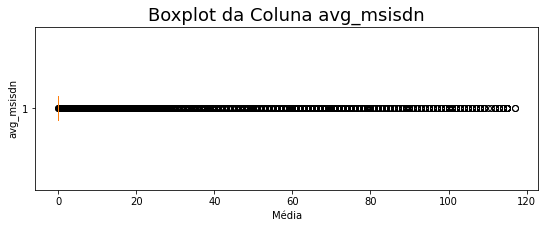

In [28]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(9, 3))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dados_droped['avg_msisdn'], vert = 0)

# Adicionando Título ao gráfico
plt.title("Boxplot da Coluna avg_msisdn", loc="center", fontsize=18)
plt.xlabel("Média")
plt.ylabel("avg_msisdn")

plt.show()

In [29]:
dados_droped['avg_cpf'].max()

117.0

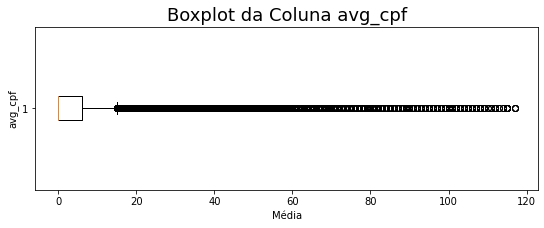

In [30]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(9, 3))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dados_droped['avg_cpf'], vert = 0)

# Adicionando Título ao gráfico
plt.title("Boxplot da Coluna avg_cpf", loc="center", fontsize=18)
plt.xlabel("Média")
plt.ylabel("avg_cpf")

plt.show()

In [31]:
# dados_droped['peso_aparelho'].unique()

In [32]:
# dados_droped['update_software'].unique()

In [33]:
dados_droped['assignedchargeamount'].describe()

count    7.892679e+06
mean     6.361465e+01
std      6.553336e+01
min     -1.367000e+02
25%      3.761000e+01
50%      5.288000e+01
75%      6.714000e+01
max      2.257980e+03
Name: assignedchargeamount, dtype: float64

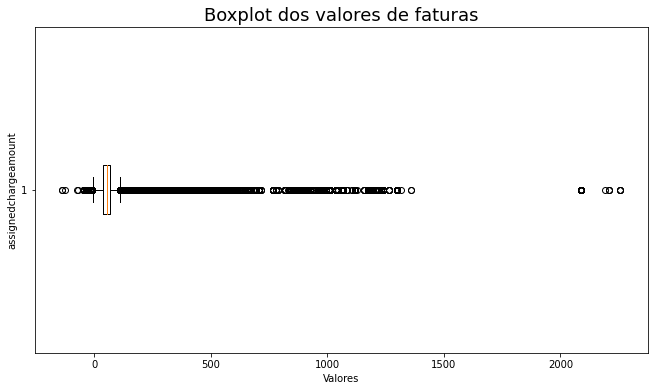

In [34]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(11, 6))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dados_droped['assignedchargeamount'],  vert = 0, patch_artist = False)

# Adicionando Título ao gráfico
plt.title("Boxplot dos valores de faturas", loc="center", fontsize=18)
plt.xlabel("Valores")
plt.ylabel("assignedchargeamount")

plt.show()

***
## Data Analysis

In [35]:
from pandas_profiling import ProfileReport

In [1]:
dados_analysis = ProfileReport(dados_droped, title="Profiling Report", progress_bar=True, infer_dtypes=False)
profile_td_html = dados_analysis.to_html()

In [ ]:
# display(HTML(profile_td_html))